In [1]:
# Calcula la precipitacion diaria media para el periodo
# 1979 - 2020 en la Cuenca del Valle de México
# utilizando la base de datos CPC.

import pandas as pd
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
path_r = "../results/onset/"
path_cpc = path_r  + "CPC_Pre/cuenca_valle_mexico/"
fname_cpc = "cuenca_valle_mexico_precip.nc"
fname_grid = "grid_points.csv"

# Se leen los límites de la cuenca.
df_grid = pd.read_csv(path_r + fname_grid)
lon_i = 360 + df_grid.lon.min()
lon_f = 360 + df_grid.lon.max() + 0.5
lat_i = df_grid.lat.min()
lat_f = df_grid.lat.max() + 0.5

# Se carga la precipitación.
pre_xr = xr.load_dataset(path_cpc + fname_cpc)
# Se recorta la zona de estudio.
pre_xr = pre_xr.sel( dict( lon = np.arange(lon_i, lon_f, 0.5),
    lat = np.arange(lat_i, lat_f, 0.5) ) )

# Quitamos los 29 de febrero.
pre_xr = ( pre_xr.sel( 
    time=~( (pre_xr.time.dt.month == 2)
    & (pre_xr.time.dt.day == 29) ) ) )

In [3]:
# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)


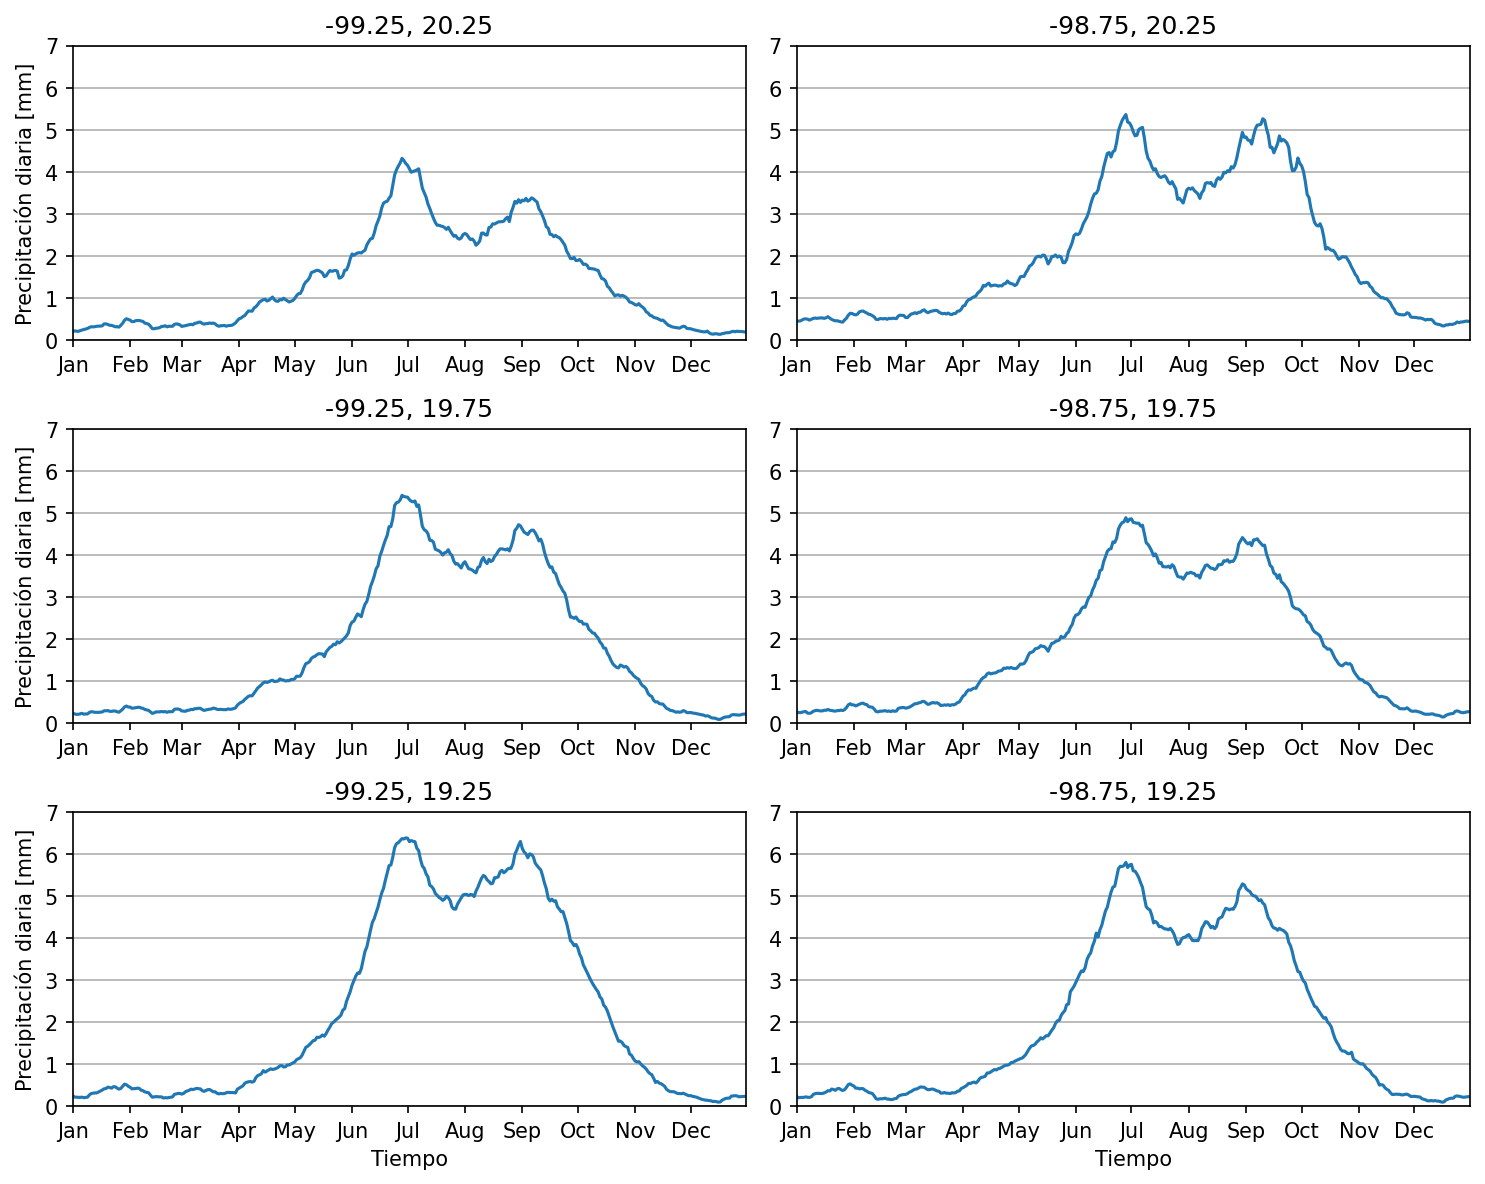

In [14]:
# Reordenamos las coordenadas.
df_grid.sort_values("lat", ascending = False, inplace = True)
df_grid.reset_index(drop = True, inplace = True)

df = pd.DataFrame()

# Agregamos una columna por cada coordenada.
for i in range( df_grid.shape[0] ):
    df[f"{df_grid.loc[i, 'lon']}, " +
        f"{df_grid.loc[i, 'lat']}"] = (
        pre_xr_mean.sel( {
            "lon": 360 + df_grid.loc[i, 'lon'],
            "lat": df_grid.loc[i, 'lat']
        } ).to_dataframe()["precip"]
        )

# Media móvil.
df = df.iloc[-15:,:].append( df.append( df.iloc[0:15,:] ) )
df = df.rolling(15, center = True).mean()
df = df.iloc[15:-15,:]

# Cambiamos de dayofyear a fecha.
df.index = pd.date_range("1995-01-01", 
    "1995-12-31", freq = "1D")

# Graficamos.
fig, axes = plt.subplots(nrows = 3, ncols = 2)
fig.set_size_inches(10, 8)
fig.set_dpi(150)

for i, ax in enumerate(axes.flatten()):
    ax.plot(df.iloc[:, i])
    ax.set_title(df.iloc[:, i].name)
    ax.grid(axis = "y")
    if i % 2 == 0:
        ax.set_ylabel("Precipitación diaria [mm]")
    if i in [4, 5]: 
        ax.set_xlabel("Tiempo")
    ax.set_ylim(0, 7)
    ax.set_xlim( pd.to_datetime("1995-01-01"),
        pd.to_datetime("1995-12-31") )
    # Formato de fecha.
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_mean_CPC.png", bbox_inches = "tight")

# Cálculos y gráficas para toda la cuenca.

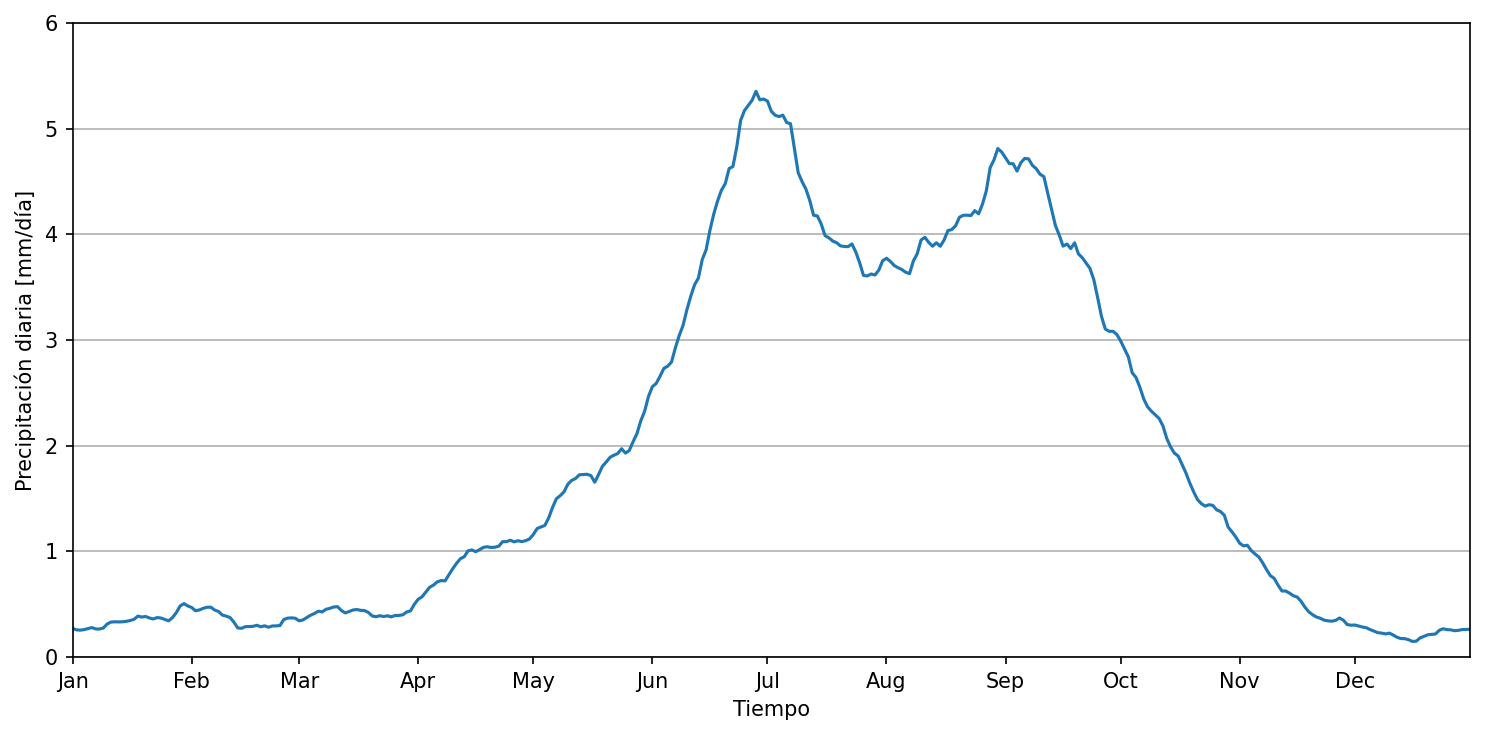

In [15]:
df_mean = df.mean(axis = 1)

# Graficamos.
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot(df_mean)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm/día]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("1995-01-01"),
    pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_mean_cuenca_CPC.png", bbox_inches = "tight")

In [7]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 5

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c +
        "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los tres
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = ( df_mean_ind[proc[1]] +
    df_mean_ind[proc[2]] + df_mean_ind[proc[3]] )
df_mean_ind[ind] = df_mean_ind[ ind
        ].where(df_mean_ind[ind] == 3, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < 3, 1)
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

Onset     : 29 May
Withdrawal: 13 October


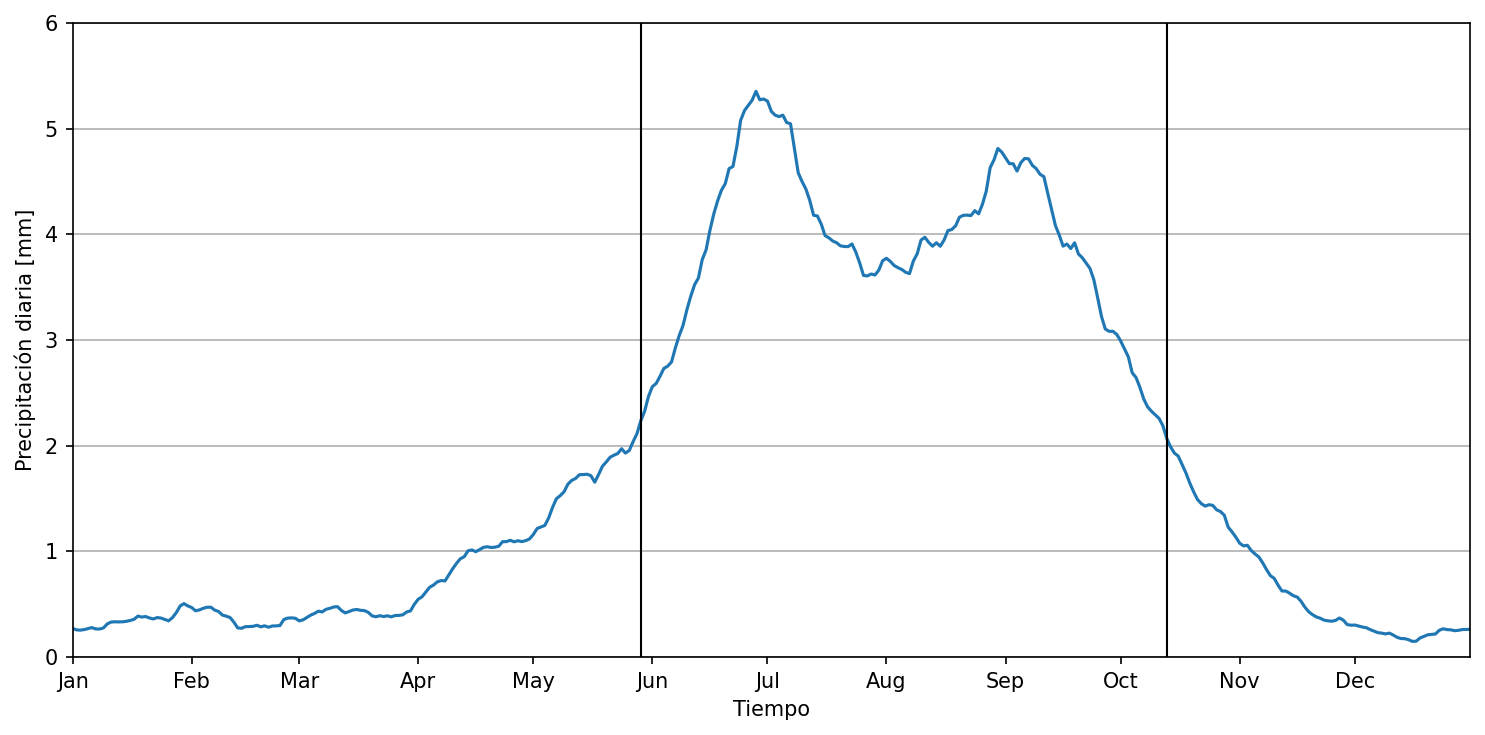

In [12]:
# Fechas.
onset = df_mean_ind.iloc[:, 1].idxmax()
withdrawal = df_mean_ind.iloc[::-1, 1].idxmax()

print(f"Onset     : {onset.day:02d}"
    + f" {onset.month_name()}")
print(f"Withdrawal: {withdrawal.day:02d}"
    + f" {withdrawal.month_name()}")

# Graficamos.
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Curva suavizada.
ax.plot(df_mean_ind.iloc[:, 0])

# Onset y withdrawal.
ax.plot( (onset, onset), (0, 6),
    color = "k", linewidth = 1 )
ax.plot( (withdrawal, withdrawal), (0, 6),
    color = "k", linewidth = 1 )

ax.set_title(df_mean_ind.iloc[:, 1].name)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("1995-01-01"),
    pd.to_datetime("1995-12-31") )
ax.set_title("")
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_ind_cuenca_CPC.png", bbox_inches = "tight")